In [1]:
import numpy as np
import pandas as pd
import pandas_dedupe
import matplotlib.pyplot as plt
import spacy
import json
import re
import tqdm
import glob

nlp = spacy.load("en_core_web_lg")

PATH_TO_FEEDS = "Feeds/*.jsonl"

## Load feeds

In [2]:
feed_addresses = glob.glob(PATH_TO_FEEDS)
feed_addresses = feed_addresses[1:]
for i, address in enumerate(feed_addresses):
    print(i, address)

0 Feeds/IQOS_search_result_2019-07-31_11_31_21.097108.jsonl
1 Feeds/Heat_Not_Burn_search_result_2019-07-24_07_48_28.067985.jsonl
2 Feeds/Vaping_search_result_2019-07-24_07_48_25.721746.jsonl


In [3]:
print("Please Enter Desired Stance for each feed. POSITIVE_sent_probas || NEGATIVE_sent_probas")
desired_stances = ["POSITIVE_sent_probas","POSITIVE_sent_probas","POSITIVE_sent_probas"] #desired stance for every feed - Must be manually input by user
assert len(desired_stances) == len(feed_addresses)


Please Enter Desired Stance for each feed. POSITIVE_sent_probas || NEGATIVE_sent_probas


In [4]:
feeds = [] # 2d-list of feeds with articles of each
total_articles = 0
for i, adress in enumerate(feed_addresses):
    feeds.append([])
    for line in open(adress):
        feeds[i].append(json.loads(line))
        total_articles +=1


print("Loaded", total_articles, "documents")
print(len(feeds))

Loaded 13431 documents
3


# Document Level Analysis with Minimal Threshold

In [5]:
#DOCUMENT LEVEL

harm_reduction_keywords = ["harm", "reduce", "alternative", "safe", "healthy", "help", "quit", "switch"]
#ensure keywords are in fact properly lemmanized
for i in range(len(harm_reduction_keywords)):
    harm_reduction_keywords[i] = nlp(harm_reduction_keywords[i])[0].lemma_.lower()
    
articles_by_date = {} # {"DATE": [[PMI related articles],[JULL related articles],[IQOS related articles]]}   
                    # record of harm reduction related articles by date

PMI = 0
JUUL = 1
IQOS = 2

#populate 
for year in range(1990,2020):
    for month in range(1,13):
        for day in range(1,32):
            
            if((month == 4 or month == 6 or month == 9 or month == 11) and day == 31 or (month == 2 and day > 28)):
                break
            
            date = str(year)+"-"
            if month < 10:
                date += "0"
            date += str(month)+"-"
            if day < 10:
                date += "0"
            date += str(day)
            articles_by_date[date] = [[],[],[]]
            
            
def format_date(string):
    return string[:10]


aliases_list = [
    ["pmi", "philip morris", "calantzopoulos"],
    ["juul", "burns"],
    ["iqos"]
]

def check_aliases(COMPANY, ents):
    for ent in ents:
        if ent.text.lower() in aliases_list[COMPANY]:
            return True
    return False


def avg_sentence_sentiment(article,desired_stance):
    temp = 0.0
    for prob in article["_source"][desired_stance]:
        if(prob != -1):
            temp += prob
    return temp / len(article["_source"][desired_stance])

## Iterate over Articles

In [6]:
THRESHOLD = .1

#iterate over feeds
for feed_number, feed in enumerate(feeds):
    #iterate over the articles
    for article in tqdm.tqdm_notebook(feed):
        date = format_date(article["_source"]["date"])

        #1. check for pro-industry
        if avg_sentence_sentiment(article,desired_stances[feed_number]) >= THRESHOLD:#article["_source"][desired_stances[feed_number]] > THRESHOLD:
            doc = nlp(article["_source"]["text"])
            

            #2. check for harm reduction keyword
            for i, word in enumerate(doc):
                if word.lemma_.lower() in harm_reduction_keywords:
                    
                    #3. check for PMI, JUUL, IQOS
                    if check_aliases(PMI,doc.ents):
                        articles_by_date[date][PMI].append(article)
                    if check_aliases(JUUL,doc.ents):
                        articles_by_date[date][JUUL].append(article)
                    if check_aliases(IQOS,doc.ents):                
                        articles_by_date[date][IQOS].append(article)

                    break


HBox(children=(IntProgress(value=0, max=1552), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1800), HTML(value='')))

KeyboardInterrupt: 

## Count Articles

In [7]:
count_by_date = {} # {"DATE":[count of PMI related docs, count of JUUL related docs, count of IQOS related docs } 
                    # counts the references to harm reduction with resepect to PMI, IQOS, JUUL
for date in articles_by_date:
    count_by_date[date] = [0,0,0]
    count_by_date[date][PMI] = len(articles_by_date[date][PMI])
    count_by_date[date][JUUL] = len(articles_by_date[date][JUUL])
    count_by_date[date][IQOS] = len(articles_by_date[date][IQOS])

In [8]:
data = np.asarray(list(count_by_date.items()))

PMI_harm_reduction = [item[PMI] for item in data[:,1]]
JUUL_harm_reduction = [item[JUUL] for item in data[:,1]]
IQOS_harm_reduction = [item[IQOS] for item in data[:,1]]
dates = list(count_by_date.keys())
years = [year[:4] for year in list(count_by_date.keys())[::12]]

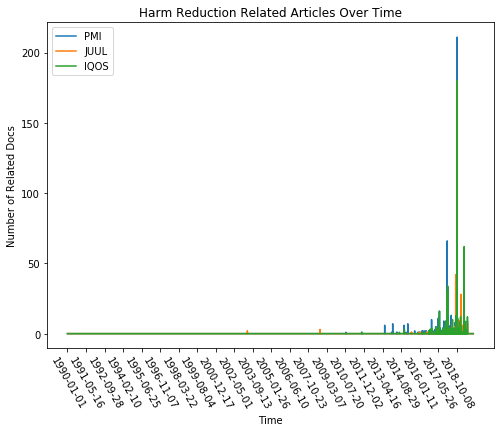

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(PMI_harm_reduction)), PMI_harm_reduction,label="PMI")
plt.plot(range(len(JUUL_harm_reduction)), JUUL_harm_reduction,label="JUUL")
plt.plot(range(len(IQOS_harm_reduction)), IQOS_harm_reduction,label="IQOS")
plt.title("Harm Reduction Related Articles Over Time")
plt.xlabel("Time")
plt.xticks(range(len(data))[::500], data[::500,0], rotation=300)
plt.ylabel("Number of Related Docs")
plt.legend()
plt.show()


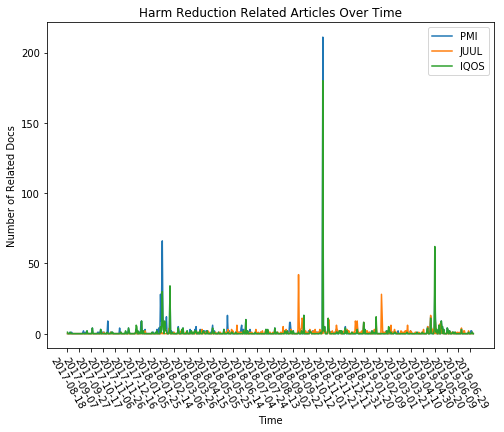

In [10]:
plt.figure(figsize=(8, 6))
start = 12*26*32 + 100
end = 12*26*35-150
plt.plot(range(len(PMI_harm_reduction))[start:end], PMI_harm_reduction[start:end],label="PMI")
plt.plot(range(len(JUUL_harm_reduction))[start:end], JUUL_harm_reduction[start:end],label="JUUL")
plt.plot(range(len(IQOS_harm_reduction))[start:end], IQOS_harm_reduction[start:end],label="IQOS")
plt.title("Harm Reduction Related Articles Over Time")
plt.xlabel("Time")
plt.xticks(range(len(dates))[start:end:20],dates[start:end:20], rotation=300)
plt.ylabel("Number of Related Docs")
plt.legend()
plt.show()

In [13]:
PMI_peak_dates = [date for date, val in count_by_date.items() if val[PMI] > 50]
IQOS_peak_dates = [date for date, val in count_by_date.items() if val[IQOS] > 50]
JUUL_peak_dates = [date for date, val in count_by_date.items() if val[JUUL] > 50]

In [15]:
for peak_date in PMI_peak_dates:
    print(peak_date, ":")
    for article in articles_by_date[peak_date][PMI]:
        print("\t", avg_sentence_sentiment(article,"POSITIVE_sent_probas"), article["_source"]["title"], "\n",  "\n")
        

2018-01-25 :
	 0.1120758768846723 FDA Scientific Committee Finds Philip Morris’ Evidence Was Inadequate to Show Its IQOS Product Would Reduce Risk of Disease 
 

	 0.10231998719841195 U.S. Panel Rejects Most of Philip Morris' iQOS Tobacco Device Claims 
 

	 0.21603084385254365 FDA Panel Skeptical of Reduced-Harm Claim for IQOS 
 

	 0.3503688453234972 IQOS Cigarette Alternative Gets Mixed Reception From FDA Panel 
 

	 0.2997609662700346 IQOS Cigarette Alternative Gets Mixed Reception From FDA Panel 
 

	 0.2174724415749748 Philip Morris sees six million U.S. smokers switching to iQOS device if cleared 
 

	 0.22751270771715826 Philip Morris sees six million US smokers switching to iQOS device if cleared 
 

	 0.20842187828672332 Philip Morris sees six million U.S. smokers switching to iQOS device if cleared 
 

	 0.20842187828672332 Philip Morris sees six million U.S. smokers switching to iQOS device if cleared 
 

	 0.20842187828672332 Philip Morris sees six million U.S. smokers swi

	 0.10683305102196658 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11337700882067545 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11337700882067545 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11636061431595639 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.11333375266013498 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.10527865104777005 Philip Morris woos puff-happy Japan for post-smoking era 
 

	 0.

In [170]:
for peak_date in IQOS_peak_dates:
    print(peak_date, ":")
    for article in articles_by_date[peak_date][IQOS]:
        print("\t", avg_sentence_sentiment(article,"POSITIVE_sent_probas"), article["_source"]["title"])

2018-02-07 :
	 0.24305004970996036 U.S. senators ask FDA to reject Philip Morris' iQOS application
	 0.24929082132875907 U.S. senators ask FDA to reject Philip Morris' iQOS application
	 0.2434554174542426 U.S. senators ask FDA to reject Philip Morris' iQOS application
	 0.24334213984283523 U.S. senators ask FDA to reject Philip Morris' iQOS application
	 0.22819894487443165 U.S. senators ask FDA to reject Philip Morris' iQOS application
	 0.21647922503983677 U.S. senators ask FDA to reject Philip Morris' iQOS application
2018-10-23 :
	 0.5110309200982251 New IQOS versions
	 0.4006283612980041 Philip Morris International Launches Next Generation of IQOS, the World’s Leading Heated Tobacco Product
	 0.4006690489186438 Philip Morris International Launches Next Generation of IQOS, the World's Leading Heated Tobacco Product
	 0.16243124837989534 Philip Morris woos puff-happy Japan for post-smoking era
	 0.20739743855956463 Heated tobacco device said to be safer than cigarettes really isn't

In [171]:
for peak_date in JUUL_peak_dates:
    print(peak_date, ":")
    for article in articles_by_date[peak_date][JUUL]:
        print("\t", avg_sentence_sentiment(article,"POSITIVE_sent_probas"), article["_source"]["title"])